<a href="https://colab.research.google.com/github/satani99/fastai_22_2/blob/main/accel_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fastai/course22p2.git
%cd course22p2

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (1176/1176), done.
remote: Compressing objects: 100% (480/480), done.
remote: Total 1176 (delta 712), reused 1117 (delta 694), pack-reused 0
Receiving objects: 100% (1176/1176), 99.81 MiB | 17.63 MiB/s, done.
Resolving deltas: 100% (712/712), done.
/content/course22p2


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.5 MB/s eta 0:00:00


In [3]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.7 MB/s eta 0:00:00


In [4]:
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [5]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [6]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(42)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [7]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean, xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [9]:
class SGD:
  def __init__(self, params, lr, wd=0.):
    params = list(params)
    fc.store_attr()
    self.i = 0

  def step(self):
    with torch.no_grad():
      for p in self.params:
        self.reg_step(p)
        self.opt_step(p)
    self.i += 1

  def opt_step(self, p): p -= p.grad * self.lr
  def reg_step(self, p):
    if self.wd != 0: p *= 1 - self.lr*self.wd

  def zero_grad(self):
    for p in self.params: p.grad.data.zero_()

In [10]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.772,0.640,0,train
0.825,0.478,0,eval
0.845,0.424,1,train
0.850,0.417,1,eval
0.865,0.372,2,train
0.847,0.412,2,eval


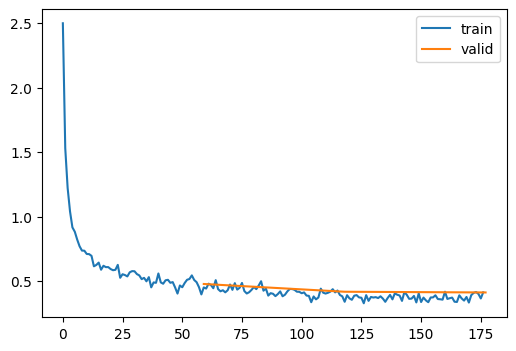

In [11]:
learn.fit(3)

In [12]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

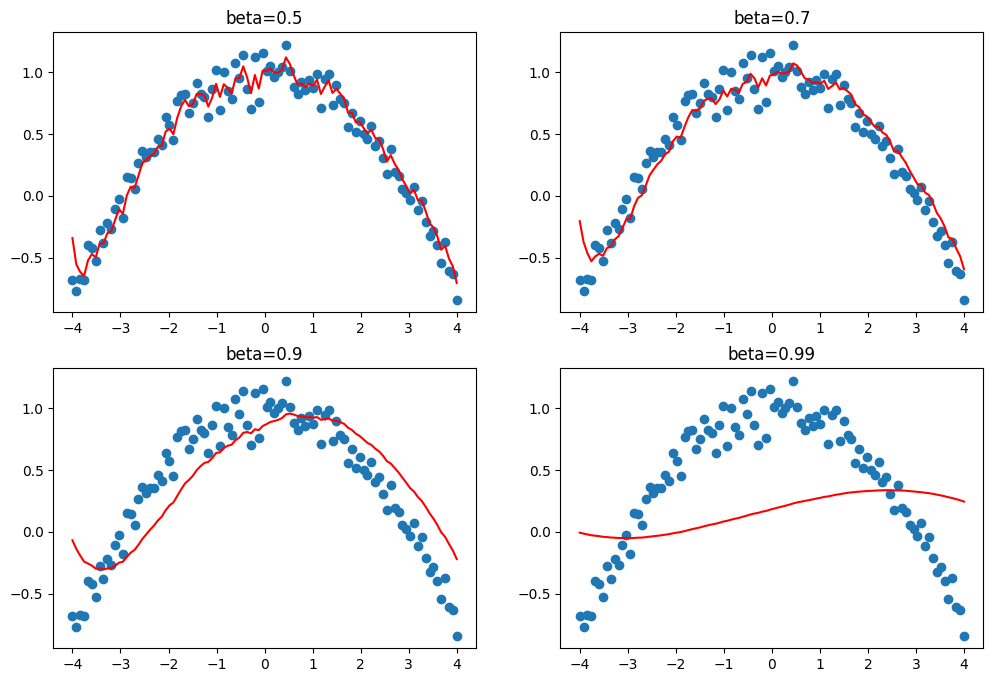

In [13]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
  ax.scatter(xs, ys)
  avg, res = 0, []
  for yi in ys:
    avg = beta * avg + (1-beta)*yi
    res.append(avg)
  ax.plot(xs, np.array(res), color='red')
  ax.set_title(f'beta={beta}')

In [14]:
class Momentum(SGD):
  def __init__(self, params, lr, wd=0., mom=0.9):
    super().__init__(params, lr=lr, wd=wd)
    self.mom = mom

  def opt_step(self, p):
    if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
    p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
    p -= self.lr * p.grad_avg

In [15]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.786,0.596,0,train
0.846,0.417,0,eval
0.869,0.359,1,train
0.861,0.372,1,eval
0.887,0.311,2,train
0.872,0.354,2,eval


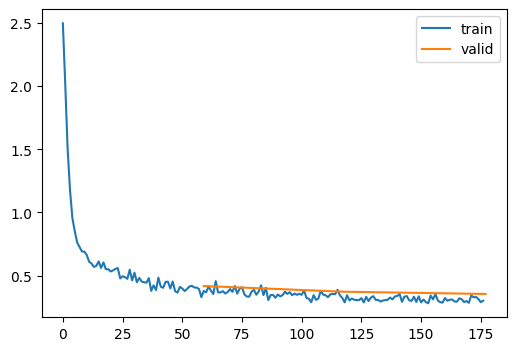

In [16]:
learn.fit(3)

In [17]:
class RMSProp(SGD):
  def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
    super().__init__(params, lr=lr, wd=wd)
    self.sqr_mom, self.eps = sqr_mom, eps

  def opt_step(self, p):
    if not hasattr(p, "sqr_avg"): p.sqr_avg = p.grad ** 2
    p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
    p -= self.lr*p.grad / (p.sqr_avg.sqrt() + self.eps)

accuracy,loss,epoch,train
0.766,0.664,0,train
0.822,0.482,0,eval
0.848,0.416,1,train
0.846,0.425,1,eval
0.866,0.367,2,train
0.851,0.400,2,eval


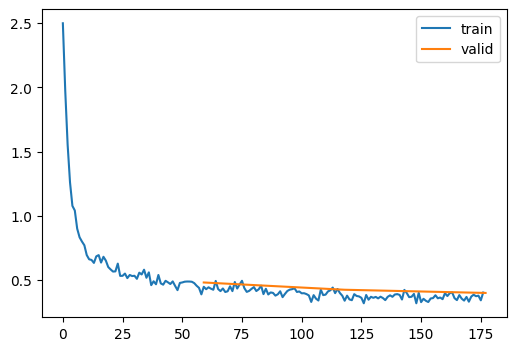

In [18]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

In [19]:
class Adam(SGD):
  def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
    super().__init__(params, lr=lr, wd=wd)
    self.beta1, self.beta2, self.eps = beta1, beta2, eps

  def opt_step(self, p):
    if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
    if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
    p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
    unbiased_avg = p.avg / (1 - (self.beta1**(self.i+1)))
    p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
    unbiased_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
    p -= self.lr * unbiased_avg / (unbiased_sqr_avg + self.eps).sqrt()


accuracy,loss,epoch,train
0.791,0.583,0,train
0.839,0.429,0,eval
0.870,0.359,1,train
0.858,0.381,1,eval
0.886,0.312,2,train
0.874,0.344,2,eval


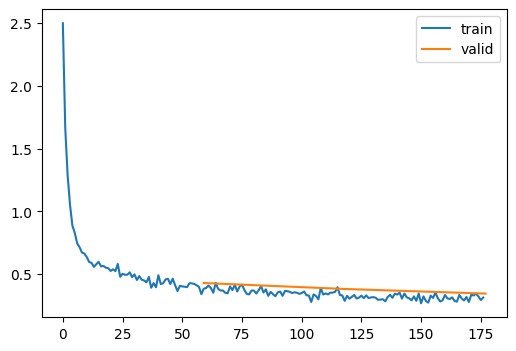

In [20]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

In [21]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [22]:
' '.join(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [23]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [24]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'add_param_group defaults load_state_dict param_groups profile_hook_step register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [25]:
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [26]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]

In [27]:
st

{'momentum_buffer': None}

In [28]:
opt.state

defaultdict(dict,
            {Parameter containing:
             tensor([[[[ 0.15, -0.19,  0.08],
                       [-0.01, -0.06,  0.26],
                       [ 0.16, -0.30,  0.23]]],
             
             
                     [[[ 0.05,  0.14,  0.03],
                       [ 0.33,  0.18, -0.04],
                       [-0.31,  0.18, -0.31]]],
             
             
                     [[[ 0.18,  0.06,  0.13],
                       [ 0.10, -0.25, -0.14],
                       [-0.07, -0.31,  0.22]]],
             
             
                     [[[-0.16, -0.16, -0.12],
                       [ 0.18, -0.00,  0.15],
                       [ 0.17, -0.01,  0.27]]],
             
             
                     [[[ 0.16,  0.19,  0.33],
                       [ 0.13,  0.27,  0.18],
                       [-0.14,  0.01, -0.17]]],
             
             
                     [[[ 0.26,  0.10, -0.23],
                       [ 0.30,  0.19,  0.02],
               

In [29]:
len(opt.param_groups)

1

In [30]:
pg = opt.param_groups[0]

In [31]:
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [32]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [33]:
sched.base_lrs

[0.006]

In [34]:
sched.get_last_lr()

[0.006]

In [35]:
def sched_lrs(sched, steps):
  lrs = [sched.get_last_lr()]
  for i in range(steps):
    sched.optimizer.step() #steps the weights/activations of the model
    sched.step() #steps the lr
    lrs.append(sched.get_last_lr())
  plt.plot(lrs)

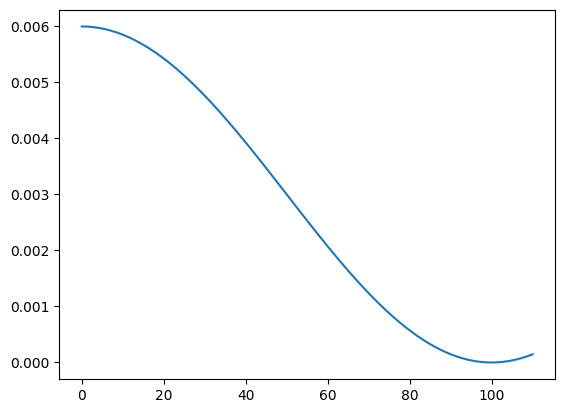

In [36]:
sched_lrs(sched, 110)

In [37]:
class BaseSchedCB(Callback):
  def __init__(self, sched): self.sched = sched
  def before_fit(self, learn): self.schedo = self.sched(learn.opt)
  def _step(self, learn):
    if learn.training: self.schedo.step()

In [38]:
class BatchSchedCB(BaseSchedCB):
  def after_batch(self, learn): self._step(learn)

In [39]:
class HasLearnCB(Callback):
  def before_fit(self, learn): self.learn = learn
  def after_fit(self, learn): self.learn = None

In [40]:
class RecorderCB(Callback):
  def __init__(self, **d): self.d = d
  def before_fit(self, learn):
    self.recs = {k:[] for k in self.d}
    self.pg = learn.opt.param_groups[0]

  def after_batch(self, learn):
    if not learn.training: return
    for k,v in self.d.items():
      self.recs[k].append(v(self))

  def plot(self):
    for k,v in self.recs.items():
      plt.plot(v, label=k)
      plt.legend()
      plt.show()

In [41]:
def _lr(cb): return cb.pg['lr']

In [42]:
len(dls.train)

59

In [43]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.806,0.525,0,train
0.847,0.415,0,eval
0.878,0.330,1,train
0.879,0.329,1,eval
0.897,0.281,2,train
0.881,0.317,2,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


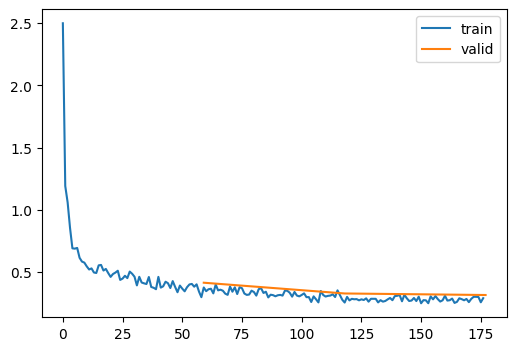

In [44]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

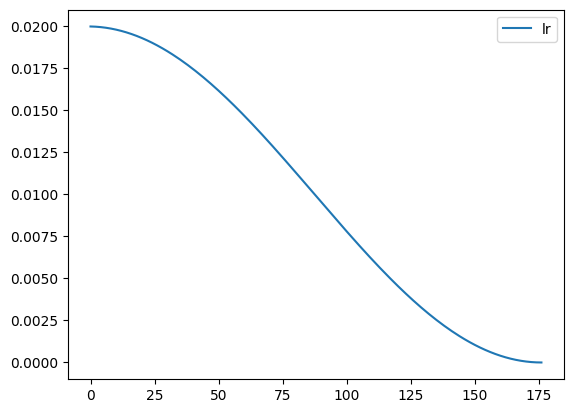

In [45]:
rec.plot()

In [47]:
class EpochSchedCB(BaseSchedCB):
  def after_epoch(self, learn): self._step(learn)

accuracy,loss,epoch,train
0.807,0.524,0,train
0.858,0.380,0,eval
0.880,0.328,1,train
0.874,0.333,1,eval
0.900,0.274,2,train
0.883,0.308,2,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


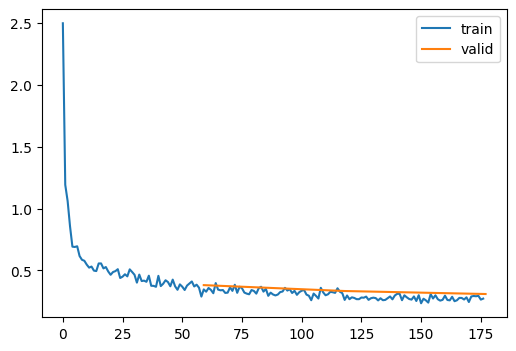

In [48]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(42)
xtra = [EpochSchedCB(sched), rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

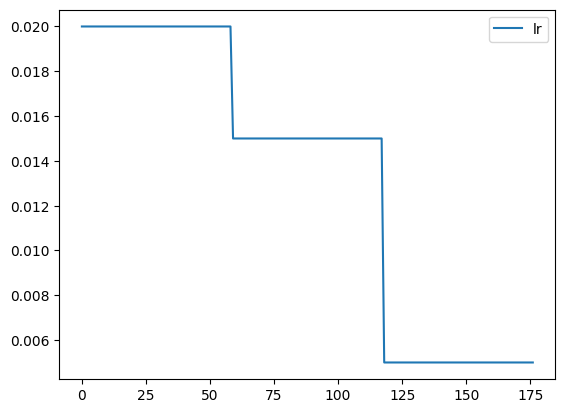

In [49]:
rec.plot()

In [50]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.767,0.660,0,train
0.843,0.462,0,eval
0.855,0.394,1,train
0.857,0.397,1,eval
0.885,0.310,2,train
0.883,0.326,2,eval
0.906,0.252,3,train
0.895,0.282,3,eval
0.921,0.216,4,train
0.900,0.270,4,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


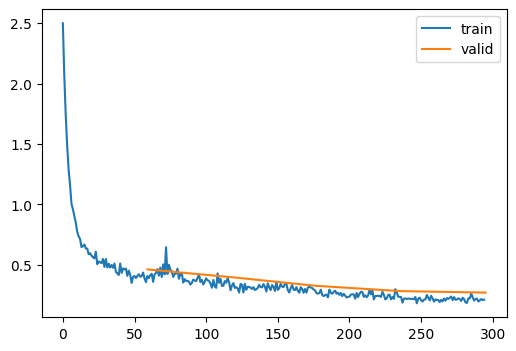

In [54]:
set_seed(42)
lr, epochs = 6e-2, 5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

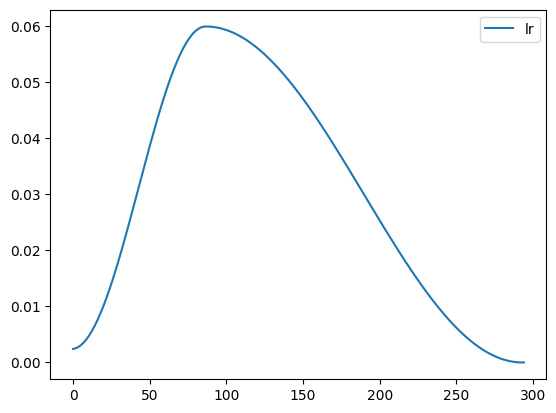

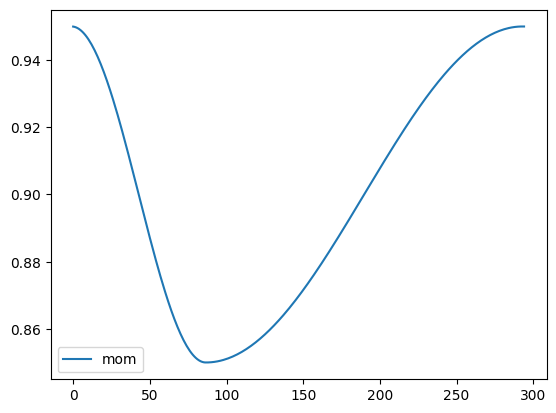

In [55]:
rec.plot()